In [1]:
pip install transformers

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,              
    llm_int8_has_fp16_weight=False
)
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it", quantization_config=bnb_config,use_auth_token="'your_token'")
model = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b-it",use_auth_token="'your_token'").to('cuda')

tokenizer1 = AutoTokenizer.from_pretrained("google/gemma-2-2b", quantization_config=bnb_config,use_auth_token="'your_token'")
model2 = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b",use_auth_token="'your_token'").to('cuda')

/home/user/.local/lib/python3.12/site-packages/transformers/models/auto/tokenization_auto.py:898: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/home/user/.local/lib/python3.12/site-packages/transformers/models/auto/auto_factory.py:476: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/user/.local/lib/python3.12/site-packages/transformers/models/auto/tokenization_auto.py:898: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/home/user/.local/lib/python3.12/site-packages/transformers/models/auto/auto_factory.py:476: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
pip install einops

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch

import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple
from typing import Callable, Any
import einops
class TopK(nn.Module):
    def __init__(self, k: int, postact_fn: Callable = nn.ReLU()) -> None:
        super().__init__()
        self.k = k
        self.postact_fn = postact_fn

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        topk = torch.topk(x, k=self.k, dim=-1)
        values = self.postact_fn(topk.values)
        # make all other values 0
        result = torch.zeros_like(x)
        result.scatter_(-1, topk.indices, values)
        return result

    def state_dict(self, destination=None, prefix="", keep_vars=False):
        state_dict = super().state_dict(destination, prefix, keep_vars)
        state_dict.update({prefix + "k": self.k, prefix + "postact_fn": self.postact_fn.__class__.__name__})
        return state_dict

    @classmethod
    def from_state_dict(cls, state_dict: dict[str, torch.Tensor], strict: bool = True) -> "TopK":
        k = state_dict["k"]
        postact_fn = ACTIVATIONS_CLASSES[state_dict["postact_fn"]]()
        return cls(k=k, postact_fn=postact_fn)
ACTIVATIONS_CLASSES = {
    "ReLU": nn.ReLU,
    "Identity": nn.Identity,
    "TopK": TopK,
}
class SAE(nn.Module):
  def __init__(self, batch_size: int,input_dim: int, expansion_factor: float = 8, device: str = 'cuda'): # Reorder arguments
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = int(input_dim * expansion_factor)
        self.decoder = nn.Linear(self.latent_dim, self.input_dim, device=device, dtype=torch.float32)
        dtype=torch.float32
        #nn.init.kaiming_uniform_(self.decoder)
        self.encoder = nn.Linear(self.input_dim, self.latent_dim, device=device, dtype=torch.float32)
        self.batch_size=batch_size
        self.device=device
        self.l1_coefficient=3.2e-5
  def encode(self, x: torch.Tensor,k) -> torch.Tensor:
        
            
      
      topk=TopK(k=k)
      return topk(self.encoder(x))
  def decode(self,encoded: torch.Tensor)-> torch.Tensor:
        return self.decoder(encoded)
  @torch.autocast(
        "cuda", dtype=torch.bfloat16, enabled=torch.cuda.is_bf16_supported() #speeds up forward by "2x"
    )
  def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    encoded=self.encode(x,128)
    final=self.decode(encoded)
    reconstruction_error_BD = (final - x).pow(2)
    reconstruction_error_B = einops.reduce(reconstruction_error_BD, 'B D -> B', 'sum')
    l2_loss = reconstruction_error_B.mean()

    
    loss = l2_loss

    nonzeros_per_sample = encoded.count_nonzero(dim=1)       

    
    avg_nonzeros = nonzeros_per_sample.float().mean() 
    return final,encoded,loss,avg_nonzeros


        

In [3]:
pip install datasets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
from datasets import load_dataset

ds = load_dataset("monology/pile-uncopyrighted",split='train', streaming=True)

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

In [144]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds2 = load_dataset("lmsys/lmsys-chat-1m",token='your_token')['train']
len(ds2)
print(ds2[106]['conversation'][1]['content'])

When it comes to visualizing a streaming platform from a business intelligence viewpoint, there are several key features that are relevant. These include:

1. User engagement: This can be measured through metrics such as the number of active users, the average time spent on the platform, and the number of streams or videos viewed.
2. Content distribution: This can be measured through metrics such as the number of channels or streams available on the platform, the number of countries or regions where the platform is available, and the number of devices or platforms on which the platform is accessible.
3. Revenue and monetization: This can be measured through metrics such as the number of paying subscribers, the average revenue per user (ARPU), and the number of advertisements viewed or clicks generated.
4. User acquisition and retention: This can be measured through metrics such as the cost of acquiring a new user, the number of new users acquired, and the percentage of users who contin

In [4]:
#this is for Lmsys-chat-1m

def tokenize_conversations(batch, tokenizer, max_len=2048):
    """
    batch: list of samples, each sample = {"conversation": [...]}

    Returns
    -------
    dict of padded tensors ready for .to(device)
    """
    
    texts = []
    for sample in batch:                    
        conv = sample["conversation"]       
        turns = [f"{t['role']}: {t['content']}" for t in conv]
        texts.append("\n".join(turns))

    ]
    enc = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )
    return enc  


#tokenized = ds2.map(
    #tokenize_conversations,
    #batched=True,
    #remove_columns=["conversation"],
#)


#tokenized.set_format("torch", columns=["input_ids", "attention_mask"])

In [10]:
from datasets import load_dataset
from torch.utils.data import DataLoader
#this is for the pile
def collate_fn(batch):
  
    texts = [example["text"] for example in batch]
   
    tokenized_batch = tokenizer(
        texts, 
        padding=True,    
        truncation=True, 
        max_length=2048, 
        return_tensors="pt"  
    )
    return tokenized_batch

from transformers import DataCollatorWithPadding


dataloader = DataLoader(
    ds2,
    batch_size=8,
    shuffle=True,
    collate_fn=lambda b: tokenize_conversations(b, tokenizer)
)

In [145]:
#this is for seeing which base features fire on different conversations
inputs = tokenizer(ds2[106]['conversation'][1]['content'], return_tensors="pt", truncation=True, padding=True).to('cuda')

activations={}
def make_hook(name):
    def hook(module, inp, out):
        
            #print(out)
            activations[name] = out[0].detach()
    return hook
block5 = model2.model.layers[14]
handle = block5.register_forward_hook(make_hook("resid_after_block5"))

with torch.no_grad():
     _ = model2(**inputs)
resid5 = activations["resid_after_block5"]


In [96]:
print(inputs['input_ids'][0][7])

print(tokenizer.decode(inputs['input_ids'][0][90]))

tensor(1889, device='cuda:0')
 the


In [146]:
new=resid5[0,:].squeeze(0)
size,_=new.shape

for i in range(size):
    
    _,encoded,_,_=base(new[i,:].unsqueeze(0))
    values,indices=torch.topk(encoded,10)

    
        
    print(i)
    print(indices)
    print(tokenizer.decode(inputs['input_ids'][0][i]))

0
tensor([[13498,  3503, 12331, 16504,  6422, 10892, 11975,  7174,   651,  1371]],
       device='cuda:0')
<bos>
1
tensor([[ 8740,  6445, 10234,  8856, 14564,  6181, 15826,  3954,  9128, 12448]],
       device='cuda:0')
When
2
tensor([[ 2412,  3408,   879,  9997, 15370, 17607,  9448, 15069, 10601, 12545]],
       device='cuda:0')
 it
3
tensor([[ 2493,  3193,  4277, 10657,  1887,  2559, 15069, 12545, 18038, 17940]],
       device='cuda:0')
 comes
4
tensor([[ 9259, 17940, 10601,  2493, 12653, 10657, 15069,  9448,  1887,  7564]],
       device='cuda:0')
 to
5
tensor([[17940, 11078,  7121,  1887, 11480,  2493,  9259, 12958,  7564,  5808]],
       device='cuda:0')
 visualizing
6
tensor([[ 9373,  6533, 13446,   716,  4274,  7564,  2493,  9259,  8995,  7056]],
       device='cuda:0')
 a
7
tensor([[ 2301,  4497, 12034,  2493, 12798, 17940,  8123,  9013,  2939,  6533]],
       device='cuda:0')
 streaming
8
tensor([[ 5766, 15700,  8123,  2493,  3098, 12034,  9824,  3093, 12778, 12421]],
       d

In [150]:
#this is for when you find a similar chat feature and test out which tokens it fires on.
for j in range(1000):
    inputs = tokenizer1(ds2[j]['conversation'][1]['content'], return_tensors="pt", truncation=True, padding=True).to('cuda')

    activations={}
    def make_hook(name):
        def hook(module, inp, out):
            
                #print(out)
                activations[name] = out[0].detach()
        return hook
    block5 = model2.model.layers[14]
    handle = block5.register_forward_hook(make_hook("resid_after_block52"))
    
    with torch.no_grad():
         _ = model2(**inputs)
    resid52 = activations["resid_after_block52"]
    new=resid52[0,:].squeeze(0)
    if new.dim()==1:
        continue
    size,_=new.shape
    
    for i in range(size):
        
        _,encoded,_,_=base(new[i,:].unsqueeze(0))
        values,indices=torch.topk(encoded,20)
        
        if 12700 in indices:
            print(j)
            print(i)
            print(indices)
            print(tokenizer.decode(inputs['input_ids'][0][i]))

0
14
tensor([[12700,  5935,  5408, 12920, 10063,  7436,  9646, 16979, 17824, 13475,
          5531,  2493,  3838,   373,  2823,  3860,  8037, 15724, 11897,   975]],
       device='cuda:0')
:
0
15
tensor([[12700, 15724, 10063,  3074, 12920,  7436, 13475, 14708,  5408,  9656,
         16346,  2493, 14130,  5935,  8780, 15080,  8233, 16970, 10657,  6858]],
       device='cuda:0')



0
16
tensor([[14535,  3463,  5408, 15724, 16346, 12530,  6418, 14400, 10063, 13475,
         14918, 11362,  3838, 16587,  9646, 12700, 16328, 12920,    26, 13980]],
       device='cuda:0')
1
0
17
tensor([[14400, 14535,  9646, 12700,  5408,  2823, 17824,  2467, 11897,  5531,
          3838, 16627,  9387, 16979,  6186,  2337, 10108,  3027,  8976, 12653]],
       device='cuda:0')
.
0
19
tensor([[ 1848,  5408,  9646,  2966,  3838,  5531,  9387, 11698,   373, 12252,
          6842,  1131, 13888,  2823, 17824, 15697, 12700, 14304, 15475, 18086]],
       device='cuda:0')
:
0
224
tensor([[15146,  8037, 14870, 10366,  

KeyboardInterrupt: 

In [84]:
inputs = tokenizer1(ds2[19]['conversation'][1]['content'], return_tensors="pt", truncation=True, padding=True).to('cuda')


print(tokenizer1.decode(inputs['input_ids'][0][68]))

#


In [ ]:
#TRAINING SCRIPT

#IF YOU WANT TO TRAIN YOUR OWN, MY SCHEME WAS FIRST TRAIN ON 125M TOKENS OF THE PILE, THEN STOP. THEN START TRAINING AGAIN ON 125M TOKENS OF LMSYS.

from torch.optim import Adam
model1=SAE(8,2304)
optimizer=Adam(model1.parameters(),lr=1e-5)
state_dict=torch.load("gemma-2-2b-it-baseline_sae_layer_14.pth")
model1.load_state_dict(state_dict)
i=8
for batch in dataloader:
    batch = {key: value.to('cuda') for key, value in batch.items()}
    activations={}
    def make_hook(name):
        def hook(module, inp, out):
        
            #print(out)
            activations[name] = out[0].detach()
        return hook
    block5 = model.model.layers[14]
    handle = block5.register_forward_hook(make_hook("resid_after_block5"))

    with torch.no_grad():
        _ = model(**batch)


    resid5 = activations["resid_after_block5"]
    #print(resid5.squeeze(0).shape)
    x2 = resid5.squeeze(0).flatten(start_dim=0, end_dim=1)
    _,_,loss,l0_loss=model1(x2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss)
    #print(l0_loss)
    

    print(i*2048)
    if i*2048>125000000:
        break
    i=i+8
    
  

# After training…
torch.save(model1.state_dict(), "gemma-2-2b-it-baseline_sae_layer_14.pth")
    
    
    

In [9]:
!nvidia-smi

Fri Apr 18 13:56:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 80GB HBM3          Off |   00000000:05:00.0 Off |                    0 |
| N/A   31C    P0            117W /  700W |   65858MiB /  81559MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [6]:
#load the final trained SAE's

base=SAE(8,2304).to('cuda')
chat=SAE(8,2304).to('cuda')

base_state_dict=torch.load("gemma-2-2b-baseline_sae_layer_14.pth")
it_state_dict=torch.load("gemma-2-2b-it-baseline_sae_layer_14.pth")
chat.load_state_dict(it_state_dict)
base.load_state_dict(base_state_dict)

/tmp/ipykernel_1330/192225215.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_state_dict=torch.load("gemma-2-2b-baseline_sae_layer_14.pth")
/tmp/ipykernel_1330/1922

<All keys matched successfully>

In [24]:
import torch

base_vectors = base.decoder.weight.T  # [18432, H]
chat_vectors = chat.decoder.weight.T  # [18432, H]
print(base_vectors.shape)
print(chat_vectors.shape)


base_norm = F.normalize(base_vectors, p=2, dim=1)
chat_norm = F.normalize(chat_vectors, p=2, dim=1)

# Matrix multiply: cosine similarity for all pairs
final_tens = torch.matmul(base_norm, chat_norm.T)  # [18432, 18432]

print(final_tens[0].shape)
max1=[]
idx=[]
for i in range(18432):
    
    max_val,max_idx = final_tens[i].max(dim=0)
    
    
    max1.append(max_val.item())
    idx.append(max_idx.item())
n=torch.tensor(max1)

vals,ind=torch.topk(n,10)
print(vals)
print(ind)

torch.Size([18432, 2304])
torch.Size([18432, 2304])
torch.Size([18432])
tensor([0.8633, 0.8477, 0.8477, 0.8281, 0.8047, 0.7969, 0.7969, 0.7930, 0.7812,
        0.7734])
tensor([ 9967, 10044, 13104,  5679, 10446, 10966, 12103,  9044,  2275,  2384])


In [80]:
max_val,max_idx=torch.topk(final_tens[6121],10)
print(max_val)
print(max_idx)

tensor([0.7070, 0.5273, 0.3398, 0.2383, 0.2031, 0.1943, 0.1670, 0.1416, 0.1416,
        0.1260], device='cuda:0', dtype=torch.bfloat16,
       grad_fn=<TopkBackward0>)
tensor([ 6364, 16011,  8248,  8090,  8123,  9304,  6548, 15359, 12833, 13301],
       device='cuda:0')


In [148]:
max_val,max_idx=torch.topk(final_tens[12700],10)
print(max_val)
print(max_idx)

tensor([0.4180, 0.3262, 0.2891, 0.2637, 0.2148, 0.1953, 0.1924, 0.1885, 0.1797,
        0.1670], device='cuda:0', dtype=torch.bfloat16,
       grad_fn=<TopkBackward0>)
tensor([15112,  3520,  5288,   792,  1984,  7233,  8417,  2742,  3878,  6456],
       device='cuda:0')


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
bins = np.linspace(0.0, 1.0, 11) 

In [14]:
hist, edges = np.histogram(max, bins=bins)

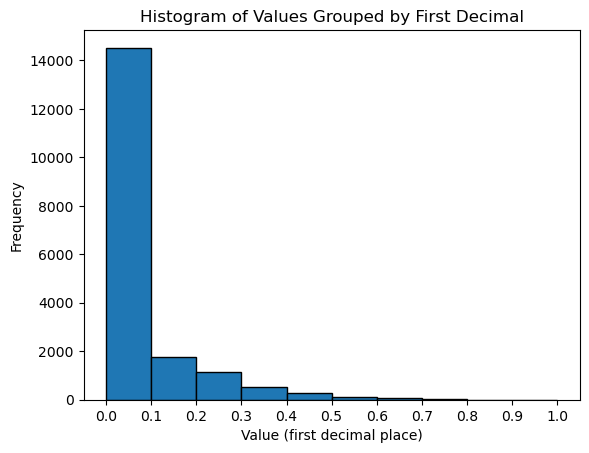

In [15]:
x = edges[:-1]             # [0.0, 0.1, 0.2, …, 0.9]
y = hist                   # corresponding frequencies



plt.bar(x, y, width=0.1, align='edge', edgecolor='black')
plt.xlabel('Cosine similarities')
plt.ylabel('Frequency')
plt.xticks(bins)           # show ticks at 0.0, 0.1, …, 1.0
plt.title('Cosine Similarities of each pair and grouped by frequency (by tenths)')
plt.show()